### IMPORT MODULES

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [2]:
# update plot formatting
mpl.rcParams.update({'font.size': 14})
mpl.rcParams.update({'mathtext.default': 'rm'})
mpl.rcParams.update({'font.family': 'sans-serif'})
mpl.rcParams.update({'font.sans-serif': 'Calibri'})

### USER INPUT

In [3]:
# output folder to read from
folder = 'outputs 2024-08-09 baseline'

In [4]:
# scenario to plot
# comment/uncomment to run each scenario
# scenario = 'delivery only'
scenario = 'closed loop'

In [5]:
# location name mapping
location_map = {
    'liquefier' : 'terminal',
    'truck' : 'transport',
    'refueling station' : 'station',
}

# function name mapping
function_map = {
    'vaporization' : 'other',
    'cooling' : 'other',
    'purchase' : 'H2 production',
    'trucking' : 'H2/LOHC trucking',
    }

# pathway name mapping
pathway_map = {
    'compressed hydrogen' : 'Compr. ${H_2}$',
    'liquid hydrogen' : 'Liq. ${H_2}$',
    'LOHC - formic acid' : 'Formic acid',
    }

In [6]:
# custom categories for sorting results
# = category order for plots

# delivery pathways
pathway_categories = [
    'compressed hydrogen', 
    'liquid hydrogen', 
    'LOHC - formic acid'
    ]

# locations
location_categories = [
    'terminal',
    'transport',
    'station'
]

# functions (transformations)
# delivery-only scenario
function_categories_1w = [
    'liquefaction',
    'compression',
    'pumping',
    'storage',
    'H2/LOHC trucking',
    'reaction',
    'separation',
    'other'
    ]

# functions (transformations)
# closed-loop scenario
function_categories_2w = [
    'H2 production',
    'CO2 recycling',
    ] + function_categories_1w

In [7]:
# subplot titles
subplot_titles = [
    'Compressed hydrogen', 
    'Liquid hydrogen', 
    'Formic acid LOHC',
    'Total system cost, all pathways',
]

In [8]:
# bar colors
# seaborn colorblind palette
# https://seaborn.pydata.org/tutorial/color_palettes.html
colors = sns.color_palette('colorblind')

# use grey for "other"
bar_colors = colors[:-3] + colors [-2:] + [colors[-3]]

In [9]:
# number of pathways
num_paths = len(pathway_categories)

In [10]:
# function categories to use for selected scenario

function_categories = function_categories_2w

if scenario == 'delivery only':
    function_categories = function_categories_1w

### READ INPUT PARAMETERS

In [11]:
# read input parameter map
df_input_params = pd.read_csv(
    os.path.join('..\outputs', folder, 'input params.csv')
    )

# extract output dollar year
output_dollar_year = df_input_params['output dollar year'].values[0]

# extract run number
run_num = df_input_params.loc[
    df_input_params['scenario'] == scenario, 'run #'].values[0]

### DATA PROCESSING

In [12]:
# read csv
f = 'output_' + str(run_num).zfill(4) + '.csv'
df = pd.read_csv(os.path.join('..\outputs', folder, f))

In [13]:
# filter results by units
df_usd_per_kg = df.loc[df['unit'] == '$/kg H2'].reset_index(drop=True)

# convert "value" columns to float
df_usd_per_kg['value'] = df_usd_per_kg['value'].astype(float)

# remap locations and functions
df_usd_per_kg['location'].replace(location_map, inplace=True)
df_usd_per_kg['function'].replace(function_map, inplace=True)

df_usd_per_kg

,pathway,process,location,function,equipment,variable group,variable name,unit,value
0,compressed hydrogen,production,terminal,H2 production,hydrogen purchase,O&M cost,purchase cost,$/kg H2,0.310000
1,compressed hydrogen,preconditioning,terminal,compression,loading compressor,capital cost,levelized capital cost,$/kg H2,0.536905
2,compressed hydrogen,preconditioning,terminal,compression,storage compressor,capital cost,levelized capital cost,$/kg H2,0.475392
3,compressed hydrogen,preconditioning,terminal,storage,compressed gas storage,capital cost,levelized capital cost,$/kg H2,0.486149
4,compressed hydrogen,preconditioning,terminal,compression,loading compressor,O&M cost,"operation, maintenance, repair costs",$/kg H2,0.099001
...,...,...,...,...,...,...,...,...,...
147,LOHC - formic acid,reconditioning,station,pumping,reactor pump,energy cost,electricity cost,$/kg H2,0.000000
148,LOHC - formic acid,reconditioning,station,other,PSA refrigerator,energy cost,electricity cost,$/kg H2,0.001384
149,LOHC - formic acid,reconditioning,station,separation,PSA,energy cost,electricity cost,$/kg H2,1.019590
150,LOHC - formic acid,reconditioning,station,compression,compressor,energy cost,electricity cost,$/kg H2,0.425336


In [14]:
# cost breakdown by pathway, location, and function

# regroup results by pathway, location, remapped function
df_func = df_usd_per_kg.groupby(
    by = ['pathway', 'location', 'function']
    )['value'].sum().reset_index()

# pivot dataframe
df_func_pivot = \
    df_func.pivot(
        columns='function',
        index=['pathway', 'location'],
        values='value',
        ).fillna(0).reset_index()

# drop columns that are all zero
df_func_pivot = df_func_pivot.loc[
    :, (df_func_pivot != 0).any(axis=0)
    ].reset_index(drop=True)
    
# sort results by custom categories
df_func_pivot['location'] = pd.Categorical(
    df_func_pivot['location'], 
    categories=location_categories
    )

df_func_pivot = \
    df_func_pivot.sort_values(
        by=['location']
        )

# capitalize location and function names
# use as axis labels
df_func_pivot['location'] = df_func_pivot['location'].str.capitalize()

df_func_pivot

function,pathway,location,CO2 recycling,H2 production,H2/LOHC trucking,compression,liquefaction,other,pumping,reaction,separation,storage
1,LOHC - formic acid,Terminal,0.000000,0.310031,0.000000,0.000000,0.000000,0.000000,0.000000,9.110470,5.593875,0.005925
4,compressed hydrogen,Terminal,0.000000,0.310000,0.000000,1.837601,0.000000,0.000000,0.000000,0.000000,0.000000,0.643369
7,liquid hydrogen,Terminal,0.000000,0.310000,0.000000,0.000000,4.435231,0.000000,0.022451,0.000000,0.000000,0.330505
2,LOHC - formic acid,Transport,10.141291,0.000000,0.994497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,compressed hydrogen,Transport,0.000000,0.000000,0.877489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,liquid hydrogen,Transport,0.000000,0.000000,0.309408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,LOHC - formic acid,Station,0.000000,0.000000,0.000000,2.604754,0.000000,0.184068,0.000000,0.170203,2.672809,0.455625
3,compressed hydrogen,Station,0.000000,0.000000,0.000000,1.868844,0.000000,0.179694,0.000000,0.000000,0.000000,0.454956
6,liquid hydrogen,Station,0.000000,0.000000,0.000000,0.000000,0.000000,0.045560,1.220412,0.000000,0.000000,0.600254


In [15]:
# calculate y-axis limit for total cost breakdown
ymax = np.ceil(
    df_func_pivot[
        function_categories].sum(axis='columns').max()
)

ymax

16.0

In [16]:
# total cost breakdown by pathway and function for all pathways

# regroup results by pathway and remapped function
df_tot_func = df_usd_per_kg.groupby(
    by = ['pathway', 'function']
    )['value'].sum().reset_index()

# pivot dataframe
df_tot_func_pivot = \
    df_tot_func.pivot(
        columns='function',
        index=['pathway'],
        values='value',
        ).fillna(0).reset_index()

# drop columns that are all zero
df_tot_func_pivot = df_tot_func_pivot.loc[
    :, (df_tot_func_pivot != 0).any(axis=0)
    ].reset_index(drop=True)

# sort results by custom categories
df_tot_func_pivot['pathway'] = pd.Categorical(
    df_tot_func_pivot['pathway'], 
    categories = pathway_categories
    )

df_tot_func_pivot = \
    df_tot_func_pivot.sort_values(
        by = ['pathway']
        )

# rename pathways
# use as axis labels
df_tot_func_pivot.replace(pathway_map, inplace=True)

df_tot_func_pivot

function,pathway,CO2 recycling,H2 production,H2/LOHC trucking,compression,liquefaction,other,pumping,reaction,separation,storage
1,Compr. ${H_2}$,0.000000,0.310000,0.877489,3.706445,0.000000,0.179694,0.000000,0.000000,0.000000,1.098326
2,Liq. ${H_2}$,0.000000,0.310000,0.309408,0.000000,4.435231,0.045560,1.242863,0.000000,0.000000,0.930759
0,Formic acid,10.141291,0.310031,0.994497,2.604754,0.000000,0.184068,0.000000,9.280673,8.266684,0.461550


In [17]:
# calculate y-axis limit for total cost breakdown
ymax_tot = np.ceil(
    df_tot_func_pivot[
        function_categories].sum(axis = 'columns').max()
)

ymax_tot

33.0

### PLOT: hydrogen cost breakdown

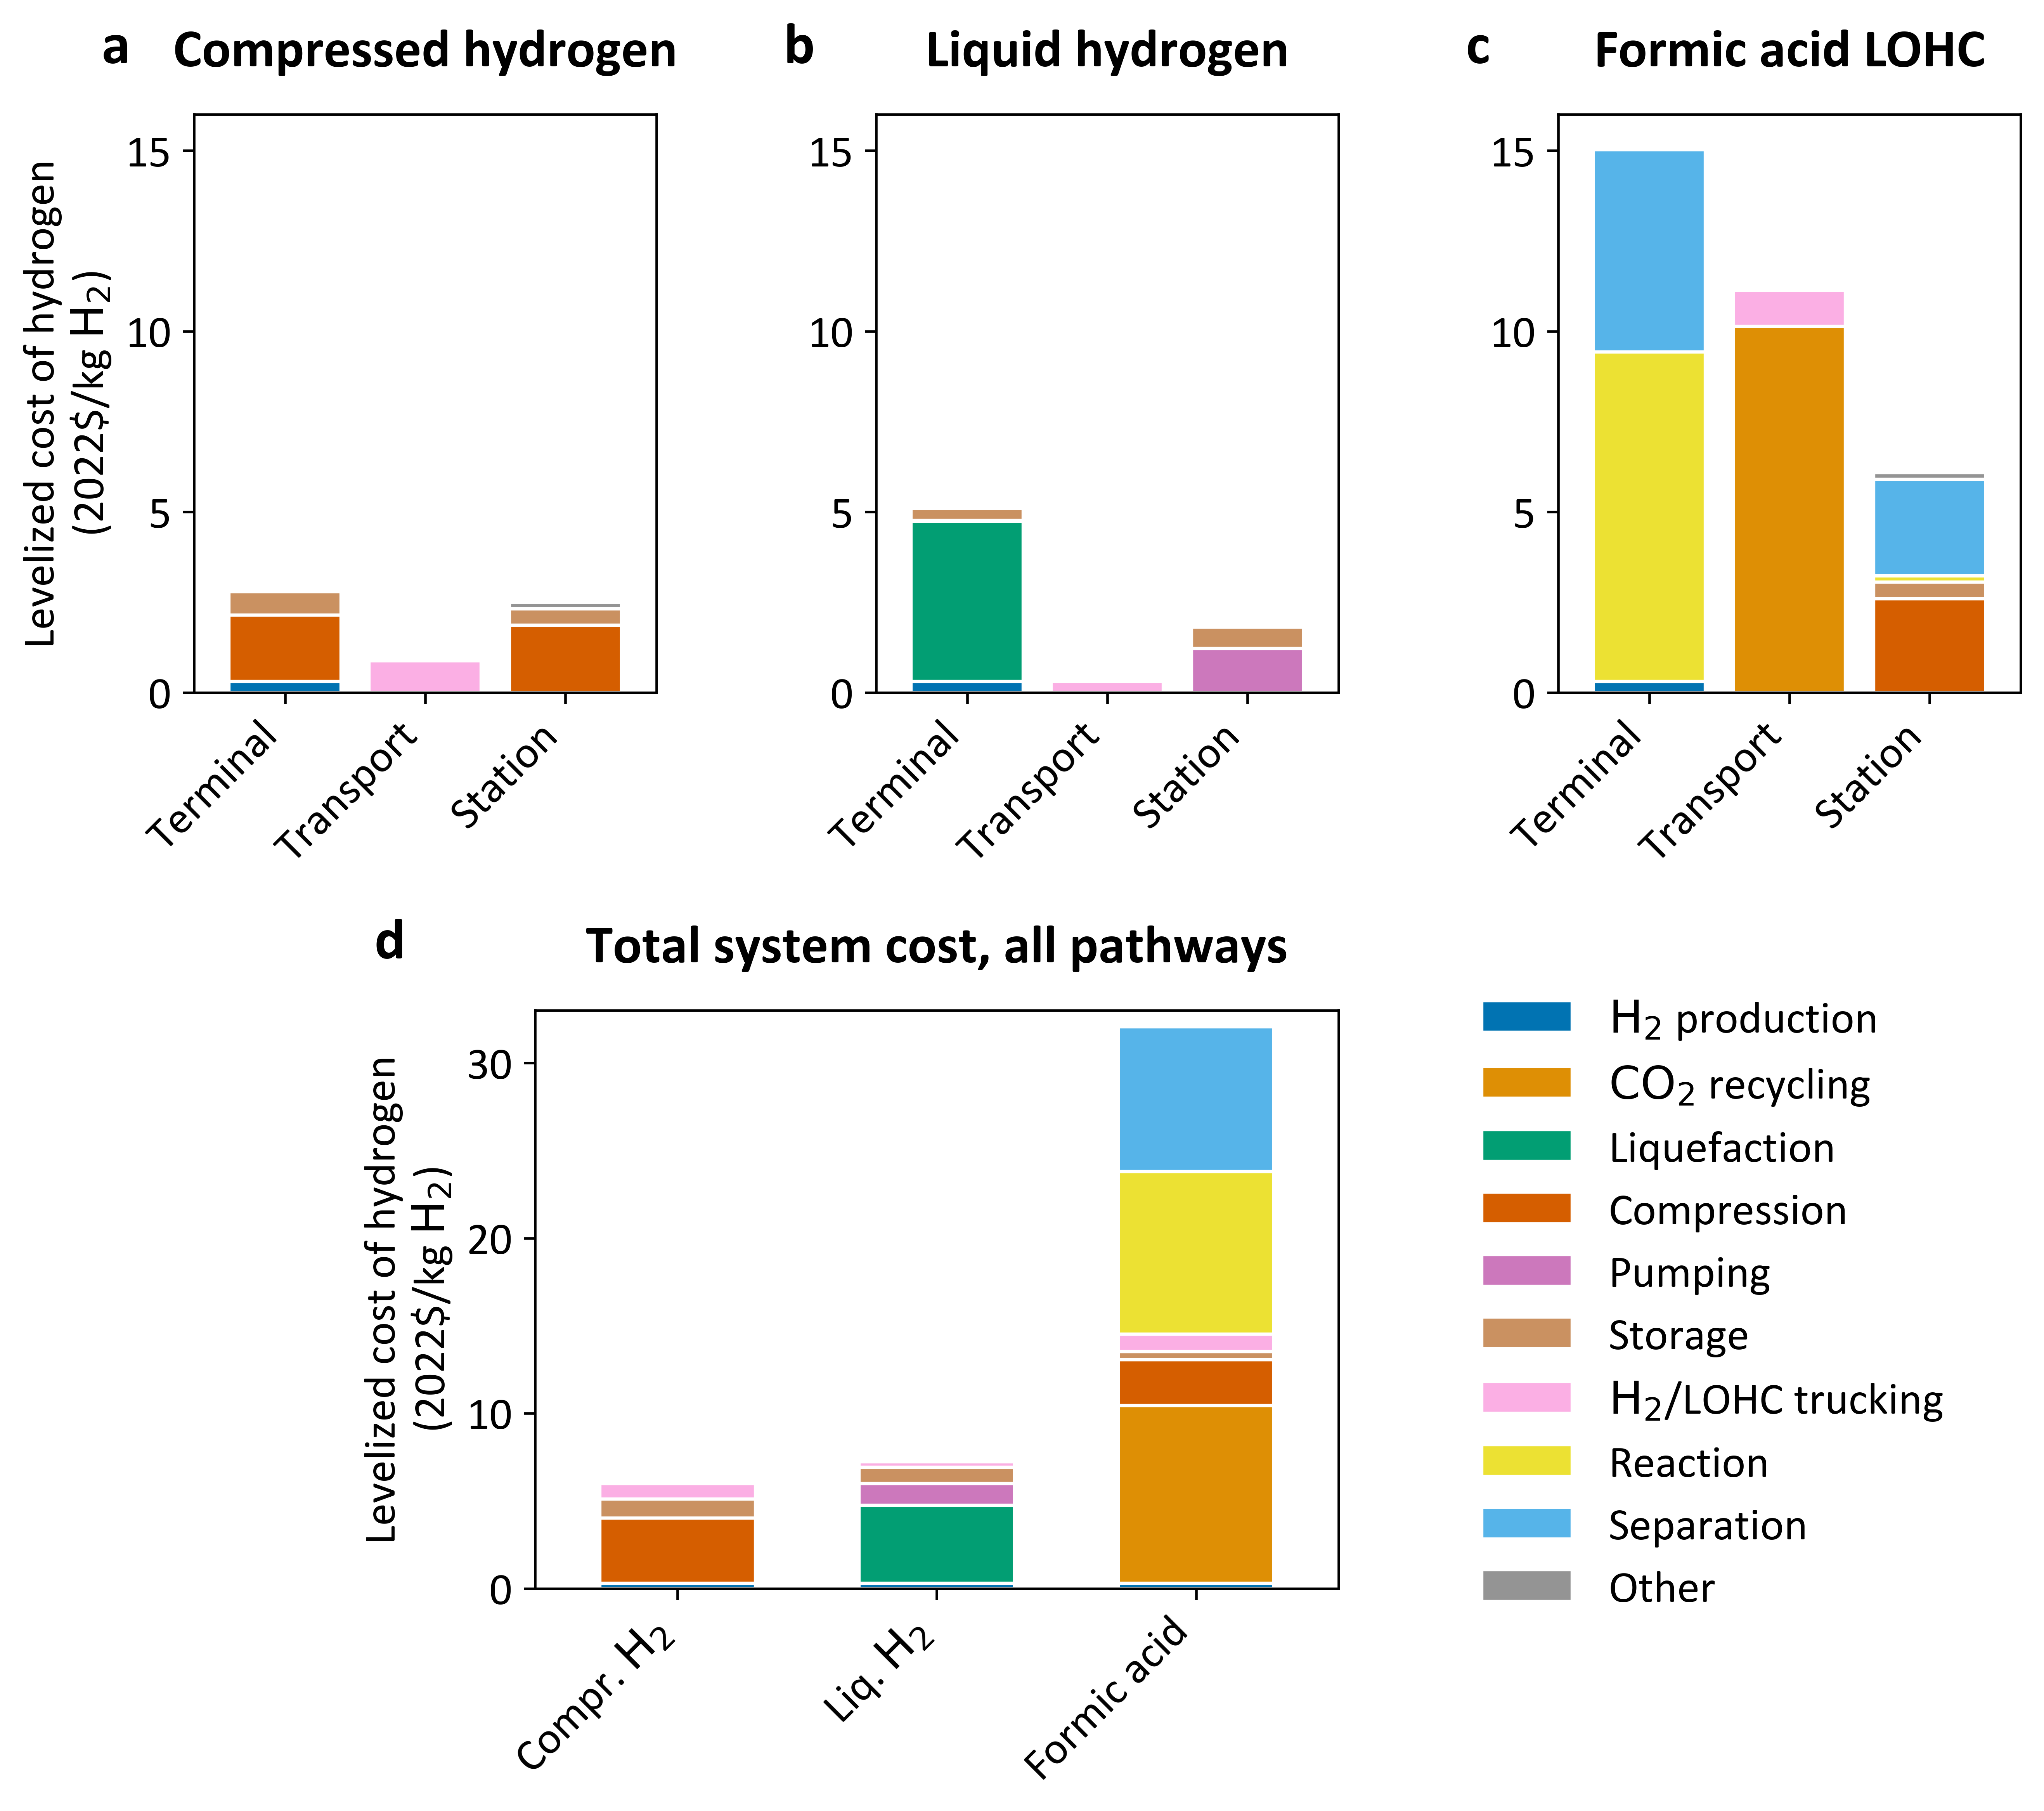

In [18]:
# create subplots
fig = plt.figure(
    layout='tight',
    figsize=(9, 8),
    dpi=600
)

gs = GridSpec(2, 2 * num_paths, figure=fig)

axes = []
for p in range(num_paths):
    axes.append(
        fig.add_subplot(gs[0:1, (0+2*p):(2+2*p)])
    )
axes.append(fig.add_subplot(gs[1:2, 1:4]))

# fill subplots
for p in range(num_paths):

    # filter results for each pathway
    df_func_p = df_func_pivot.loc[
        df_func_pivot['pathway'] == pathway_categories[p]
        ].reset_index(drop=True)
    
    # plot results for each pathway
    df_func_p.plot.bar(
        ax=axes[p],
        x='location',
        y=function_categories,
        ylim=(0, ymax),
        stacked=True,
        width=0.8,
        color=bar_colors[-len(function_categories):],
        edgecolor='white',
    )
        
# plot total cost breakdown for all pathways
df_tot_func_pivot.plot.bar(
    ax=axes[-1],
    x='pathway',
    y=function_categories,
    ylim=(0, ymax_tot),
    stacked=True,
    width=0.6,
    color=bar_colors[-len(function_categories):],
    edgecolor='white',
)

# update subplot titles and numbering
text = ['a', 'b' , 'c', 'd']

for i in range(len(axes)):
    axes[i].set_title(
        subplot_titles[i],
        fontweight='bold',
        pad=15
    )

    axes[i].annotate(
        text[i], 
        xy=(-0.2, 1.09), 
        xycoords='axes fraction', 
        annotation_clip=False,
        fontsize=18,
        fontweight='bold'
    )
    
# remove legend and x-axis label from subplot
for ax in axes:
    ax.get_legend().remove()
    ax.set_xlabel('')

# update axis settings
for ax in axes:
    ax.set_xticks(
        ax.get_xticks(), 
        ax.get_xticklabels(), 
        rotation=45,
        ha='right',
    )

for i in [0, -1]:
    axes[i].set_ylabel(
        'Levelized cost of hydrogen\n' + \
        '({}\\$/kg'.format(output_dollar_year) + ' ${H_2}$)')

# add legend for figure
handles, labels = axes[-1].get_legend_handles_labels()

labels_new = []
for label in labels:
    label = label.replace('H2', '${H_2}$')
    label = label.replace('CO2', '${CO_2}$')
    if any(s in label.split()[0] for s in ['${H_2}$', '${CO_2}$', 'LOHC']):
        labels_new.append(label)
    else:
        labels_new.append(label.capitalize())

fig.legend(
    handles=handles, 
    labels=labels_new, 
    frameon=False, 
    bbox_to_anchor=(0.7, 0.1), 
    loc='lower left'
    )

# save plot
plt.savefig(
    'cost breakdown_' + scenario + '.png',
    bbox_inches='tight'
    )
    
# show plot
plt.show()